## Imports

In [1]:
import torch
import cv2
import os
import torch.nn.parallel
import modules, net, resnet, densenet, senet
import loaddata_demo as loaddata
import argparse
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import random
from demo_transform import *

from volume import get_volume
from mask import get_mask

In [2]:
args_input = './input'
args_output = './output'

In [3]:
def _check_path(path):
    if not os.path.exists(path):
        print('directory {path} not exist.')
        return False
    return True

def define_model(target):
    model = None
    if target is 'resnet':
        original_model = resnet.resnet50(pretrained=True)
        encoder = modules.E_resnet(original_model)
        model = net.model(encoder, num_features=2048, block_channel=[256, 512, 1024, 2048])
    elif target is 'densenet':
        original_model = densenet.densenet161(pretrained=True)
        encoder = modules.E_densenet(original_model)
        model = net.model(encoder, num_features=2208, block_channel=[192, 384, 1056, 2208])
    elif target is 'senet':
        original_model = senet.senet154(pretrained='imagenet')
        encoder = modules.E_senet(original_model)
        model = net.model(encoder, num_features=2048, block_channel=[256, 512, 1024, 2048])
    return model

def _single_dataloader(filename):
    __imagenet_stats = {'mean': [0.485, 0.456, 0.406],
                        'std': [0.229, 0.224, 0.225]}

    image_trans = loaddata.depthDataset(filename,
                                        transform=transforms.Compose([
                                            Scale([320, 240]),
                                            CenterCrop([304, 228]),
                                            ToTensor(),
                                            Normalize(__imagenet_stats['mean'],
                                                      __imagenet_stats['std'])
                                        ]))
    image = DataLoader(image_trans, batch_size=1, shuffle=False, num_workers=0, pin_memory=False)
    return image

## Loading model

In [4]:
if not _check_path(args_output):
    os.makedirs(args_output)
models = ['resnet', 'densenet', 'senet']
model = define_model(target=models[2])
model = torch.nn.DataParallel(model).cuda()
model.load_state_dict(torch.load('./pretrained_model/model_senet'))
model.eval()
'model loaded.'




'model loaded.'

## Samples

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def test(nyu2_loader, model, width, height, img_id):
    for i, image in enumerate(nyu2_loader):

        image = torch.autograd.Variable(image).cuda()
        out = model(image)
        out = out.view(out.size(2), out.size(3)).data.cpu().numpy()
        max_pix = out.max()
        min_pix = out.min()
        out = (out - min_pix) / (max_pix - min_pix) * 255
        out = cv2.resize(out, (width, height), interpolation=cv2.INTER_CUBIC)

        op_dir = f'{args_output}/{img_id}'
        if not os.path.exists(op_dir):
            os.mkdir(op_dir)

        cv2.imwrite(f'{op_dir}/grey.png', out)        
        
        out_grey = cv2.imread(f'{op_dir}/grey.png', 0)
        out_color = cv2.applyColorMap(out_grey, cv2.COLORMAP_JET)

        cv2.imwrite(f'{op_dir}/color.png', out_color)
        
        

In [36]:
img_pool = os.listdir(args_input)
import random
# random.shuffle(img_pool)
it = iter(img_pool)

_t11.png


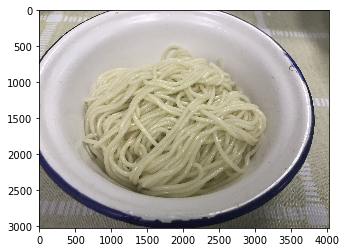

In [40]:
img_name = next(it)
img_id, suffix = img_name.split('.')
while suffix.lower() not in ['jpg', 'png']:
    img_name = next(it)
    img_id, suffix = img_name.split('.')
    
print(img_name)
    
img = cv2.imread(f'{args_input}/{img_name}')
plt.imshow(plt.imread(f'{args_input}/{img_name}'))

loader = _single_dataloader(f'{args_input}/{img_name}')
test(loader, model, img.shape[1], img.shape[0], img_id)

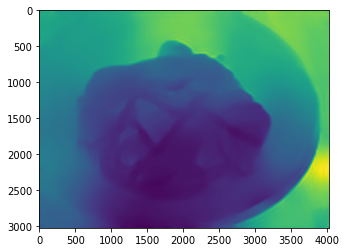

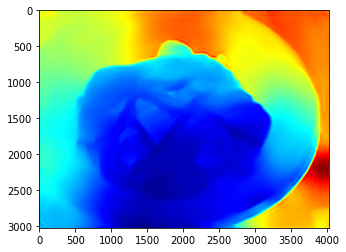

In [41]:
img = cv2.imread(f'{args_output}/{img_id}/grey.png')
plt.imshow(plt.imread(f'{args_output}/{img_id}/grey.png'))
plt.show()
img = cv2.imread(f'{args_output}/{img_id}/color.png')
plt.imshow(plt.imread(f'{args_output}/{img_id}/color.png'))
plt.show()